In [ ]:
import os
import tarfile
import urllib.request as req

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

# 下载数据
def fetch_housing_data(houseing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    req.urlretrieve(houseing_url, tgz_path)  # 将数据下载到本地
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)  # 解压文件到指定路径
    housing_tgz.close()
    
fetch_housing_data()

In [129]:
import pandas as pd

# 加载数据
def load_housing_data(data_path):
    return pd.read_csv(data_path)
housing = load_housing_data("datasets/housing/housing.csv")

## 查看数据结构

In [130]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [131]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [132]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


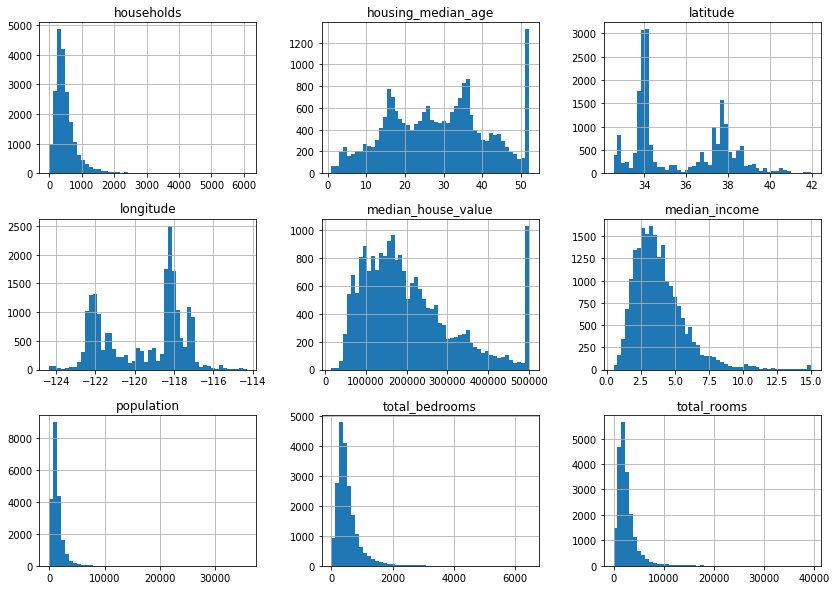

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

housing.hist(bins=50, figsize=(14, 10))
plt.show()

## 创建测试集
在这个阶段就要分割数据，防止在接下来探索数据时产生数据透视偏差

In [134]:
# 切分数据，创建测试集
from sklearn.model_selection import train_test_split

#  train_test_split属于纯随机采样，样本数量大时很适合
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
train_set.shape

(16512, 10)

In [135]:
import numpy as np

# 我们的数据集不是很大，使用train_test_split容易出现采样偏差的风险
# 进行分层采样

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) # ceil对值舍入（以产生离散的分类）除以1.5是为了限制收入分类的数量
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # 将所有大于 5的分类归入到分类 5

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]): 
    start_train_set = housing.loc[train_index]
    start_test_set = housing.loc[test_index]

# 剔除income_cat属性
for set in (start_train_set, start_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)
start_train_set.shape

(16512, 10)

## 数据探索和可视化，发现规律
查看过数据了，现在需要对数据进行了解。
只研究训练集，如果训练集非常大的时候还需要再弄一个探索集用来加快运行速度。（本例子不需要）

In [136]:
# 创建一个副本，以免损伤训练集
housing = start_train_set.copy()

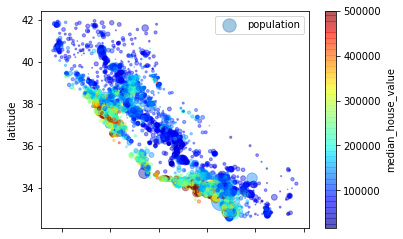

In [137]:
# 地理数据可视化
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
# 每个圈的半径表示街区的人口（选项`s`），颜色代表价格（选项`c`）
plt.legend()

In [138]:
# 查找关联
corr_matrix = housing.corr()  # corr()方法可以计算出每对属性间的标准相关系数
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CC8F0BD320>,
      dtype=object)

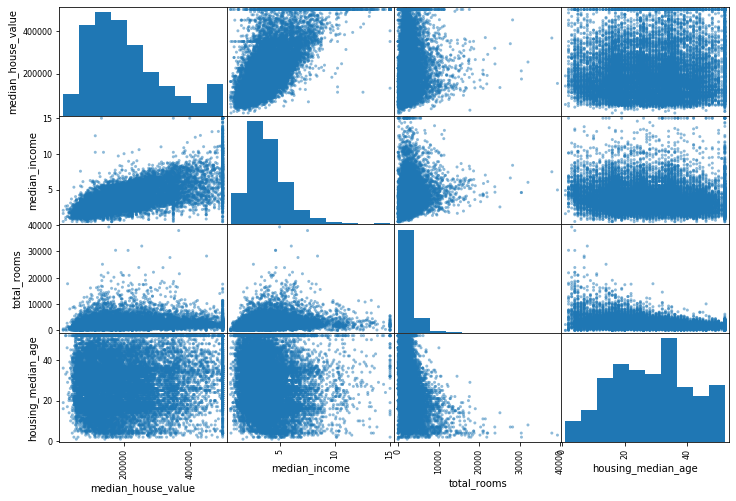

In [139]:
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))

### 属性组合实验

In [140]:
housing["rooms_per_bedrooms"] = housing["total_rooms"] / housing["total_bedrooms"]
housing["rooms_per_holds"] = housing["total_rooms"] / housing["households"]
housing["population_per_holds"] = housing["population"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.687160
rooms_per_bedrooms      0.385271
rooms_per_holds         0.146285
total_rooms             0.135097
housing_median_age      0.114110
households              0.064506
total_bedrooms          0.047689
population_per_holds   -0.021985
population             -0.026920
longitude              -0.047432
latitude               -0.142724
Name: median_house_value, dtype: float64

## 为机器学习算法准备数据


In [141]:
# 分开特征和标签
housing = start_train_set.drop(["median_house_value"], axis=1)
housing_label = start_train_set["median_house_value"]

### 缺失值处理
只有 "total_bedrooms" 字段有缺失

In [142]:
# housing = housing.dropna(subset=["total_bedrooms"])  # 删除含有缺失值的样本
# housing = housing.drop(["total_bedrooms"], axis=1)  # 删除含有缺失值的特征，若该特征缺失值较多
# pd填补缺失值
median = housing["total_bedrooms"].median
housing["total_bedrooms"].fillna(median)

17606     351
18632     108
14650     471
3230      371
3555     1525
19480     588
8879      317
13685     293
4937      465
4861      229
16365     951
19684     559
19234     501
13956     582
2390      495
11176     649
15614     545
2953      251
13209     409
6569      261
5825      913
18086     538
16718     945
13600     278
13989     444
15168     190
6747      563
7398      366
5562      133
16121     416
         ... 
12380     767
5618       24
10060     539
18067     438
4471      797
19786     300
9969      393
14621    1051
579       302
11682    1615
245       460
12130     537
16441     544
11016     428
19934     422
1364       34
1236      829
5364      272
11703     300
10356     449
15270     515
3754      373
12166     756
6003      932
7364      212
6563      236
12053     294
13908     872
11159     380
15775     682
Name: total_bedrooms, Length: 16512, dtype: object

In [143]:
# 使用sklearn中的simpleimputer处理缺失值
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# 创建一份不包含文本类型特征”ocean_proximity“的数据副本
housing_num = housing.drop(["ocean_proximity"], axis=1)
housing_num_nonan = imputer.fit_transform(housing_num)
housing_num_nonan = pd.DataFrame(housing_num_nonan, columns=housing_num.columns)
housing_num_nonan.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### 处理文本和类别属性

In [144]:
# LabelEncoder能将文本标签映射为数值0，1，2，3...等，会误导算法
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [145]:
# OneHotEncoder能将数值分类转换为稀疏矩阵
from sklearn.preprocessing import OneHotEncoder

encoder_1hot = OneHotEncoder()
housing_cat_1hot = encoder_1hot.fit_transform(housing_cat_encoded.reshape(-1, 1))
# fit_transform()用于 2D 数组，而housing_cat_encoded`是一个 1D 数组，所以需要将其变形
# housing_cat_1hot结果是一个稀疏矩阵，即只存储非零项。这是为了当分类很多时节省内存。 将其转换成numpy数组需要用到toarray函数
housing_cat_1hot.toarray()

# 使用类LabelBinarizer，可以用一步执行这两个转换（从文本分类到整数分类，再从整数分类到独热向量）

C:\Users\1\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### 数值型数据进行特征所放
消除特征间量纲的影响

In [146]:
# 可标准化也可归一化
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
housing_num_standscaler = ss.fit_transform(housing_num_nonan)
housing_num_standscaler[0:5]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555],
       [ 0.49247384, -0.65929936, -0.92673619,  1.85619316,  2.41221109,
         2.72415407,  2.57097492, -0.44143679]])

### 自定义转换器

In [164]:
# 实现增加["rooms_per_bedrooms","rooms_per_holds","population_per_holds"]特征的转换器
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_bedrooms = X[:, rooms_ix] / X[:, bedrooms_ix]
        rooms_per_holds = X[:, rooms_ix] / X[:, household_ix]
        population_per_holds = X[:, population_ix] / X[:, household_ix]
        return np.c_[X, rooms_per_bedrooms, rooms_per_holds, population_per_holds]

attr_addr = CombineAttributesAdder()
housing_extra_attr = attr_addr.transform(housing.values)
housing_extra_attr.shape

(16512, 12)

In [165]:
# 自定义DataFrame转换器

class DataframeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.attribute_names].values
    
dataframe_selector = DataframeSelector(list(housing_num.columns))
housing_values = dataframe_selector.fit_transform(housing)
housing_values[0]

array([-121.89  ,   37.29  ,   38.    , 1568.    ,  351.    ,  710.    ,
        339.    ,    2.7042])

In [166]:
# 由于sklearn版本更新使得LabelBinarizer的fit_transform只能接受两个参数，
# 直接运行的话会报错，所以重写一个转化器，只接受一个参数。
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
        
    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self
    
    def transform(self, X, y=None):
        return self.encoder.transform(X)

### 完整的处理数值以及类别属性的流水线

In [167]:
from sklearn.pipeline import FeatureUnion, Pipeline

num_attributes = list(housing_num.columns)
cat_attribute = ["ocean_proximity"]

num_pipeline = Pipeline([
    ("selector", DataframeSelector(num_attributes)),
    ("imputer", SimpleImputer(strategy="median")),
    ("attr_addr", CombineAttributesAdder()),
    ("std_scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("selector", DataframeSelector(cat_attribute)),
    ("Mylabel_binarizer", MyLabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [168]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared[0]

array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
       -0.63621141, -0.42069842, -0.61493744, -0.42732528, -0.31205452,
       -0.08649871,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [169]:
housing_prepared.shape

(16512, 16)

## 选择并训练模型

### 线性模型训练与评估

In [178]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [189]:
# rmse评估
from sklearn.metrics import mean_squared_error
import numpy as np

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_label, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse  # 模型欠拟合

68724.2090974693

In [191]:
# 交叉验证
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(line_reg, housing_prepared, housing_label,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)  # line_scores 越大越好
lin_rmse_scores  # 越小越好

array([67016.03042064, 67128.67109626, 68051.68782637, 74860.77896327,
       68456.85856405, 71477.5050075 , 65130.1004029 , 68492.97827394,
       71779.07637352, 67967.00158847])

In [194]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())  # 就是RMSE
    print("Standard deviation:", scores.std())

In [195]:
display_scores(lin_rmse_scores)

Scores: [67016.03042064 67128.67109626 68051.68782637 74860.77896327
 68456.85856405 71477.5050075  65130.1004029  68492.97827394
 71779.07637352 67967.00158847]
Mean: 69036.0688516917
Standard deviation: 2704.248553371779


### 决策树模型

In [196]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_label)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [197]:
# rmse
tree_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_label, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [205]:
# 交叉验证

scores = cross_val_score(tree_reg, housing_prepared, housing_label, 
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [68578.50629271 66859.85842649 72081.79702718 68605.80342445
 70838.95976107 75237.48050008 71110.5348897  70889.18050007
 77349.61569559 70300.13748054]
Mean: 71185.18739978803
Standard deviation: 2972.844147303775


### 随机森林

In [206]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(housing_prepared, housing_label)

C:\Users\1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [219]:
# rmse
rf_predictions = rf.predict(housing_prepared)
scores = mean_squared_error(housing_label, rf_predictions)
rf_rmse_scores = np.sqrt(scores)
rf_rmse_scores

22568.335420091906

In [215]:
# 交叉验证
scores = cross_val_score(rf, housing_prepared, housing_label, 
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

Scores: [50730.22925822 50563.36649803 52446.79528534 54675.33261576
 51580.17012668 54458.00760803 51796.74051403 50350.5594844
 56593.31251822 52937.87773653]
Mean: 52613.239164524435
Standard deviation: 1955.269877896496


### 模型微调

In [220]:
# 网格搜索
from sklearn.model_selection import GridSearchCV

param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid=param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_label)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],

In [221]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [222]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [226]:
# 得到评估得分
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63886.938345130366 {'max_features': 2, 'n_estimators': 3}
55181.73641425298 {'max_features': 2, 'n_estimators': 10}
52439.4943103788 {'max_features': 2, 'n_estimators': 30}
59459.11702366768 {'max_features': 4, 'n_estimators': 3}
52553.74993659825 {'max_features': 4, 'n_estimators': 10}
50442.82594760653 {'max_features': 4, 'n_estimators': 30}
60009.41904834152 {'max_features': 6, 'n_estimators': 3}
51621.136321253485 {'max_features': 6, 'n_estimators': 10}
49561.29952583037 {'max_features': 6, 'n_estimators': 30}
58006.166673396976 {'max_features': 8, 'n_estimators': 3}
51943.81654712946 {'max_features': 8, 'n_estimators': 10}
49724.199370936374 {'max_features': 8, 'n_estimators': 30}
62615.51917989284 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54019.03168638991 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59456.608415628776 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52204.83282649325 {'bootstrap': False, 'max_features': 3, 'n_estimators'

### 分析最佳模型和他们的误差

In [228]:
# 可以得到属性对于做出准确预测的相对重要性
feature_importences = grid_search.best_estimator_.feature_importances_
feature_importences

array([6.77220366e-02, 6.21190369e-02, 4.44025576e-02, 1.84542013e-02,
       1.74495224e-02, 1.80521531e-02, 1.63374422e-02, 3.66295445e-01,
       5.91084448e-02, 5.25216680e-02, 1.06976245e-01, 7.91287775e-03,
       1.55158082e-01, 1.15525912e-04, 2.92851956e-03, 4.44624067e-03])

In [236]:
extra_attribs = ["rooms_per_bedrooms", "rooms_per_holds", "population_per_holds"]

cat_onehot_attributes = list(encoder.classes_)
attributes = num_attributes + cat_onehot_attributes + extra_attribs

sorted(zip(attributes, feature_importences), reverse=True)

[('total_rooms', 0.018454201288386055),
 ('total_bedrooms', 0.017449522390825995),
 ('rooms_per_holds', 0.0029285195564460902),
 ('rooms_per_bedrooms', 0.000115525912343601),
 ('population_per_holds', 0.004446240665309828),
 ('population', 0.018052153067882156),
 ('median_income', 0.36629544535706327),
 ('longitude', 0.06772203662909468),
 ('latitude', 0.06211903690610206),
 ('housing_median_age', 0.04440255762666674),
 ('households', 0.016337442217848417),
 ('NEAR OCEAN', 0.15515808248474794),
 ('NEAR BAY', 0.007912877749721986),
 ('ISLAND', 0.1069762452806312),
 ('INLAND', 0.05252166804227308),
 ('<1H OCEAN', 0.05910844482465698)]

## 用测试集评估系统

In [238]:
final_model = grid_search.best_estimator_

x_test = start_test_set.drop(["median_house_value"], axis=1)
y_test = start_test_set["median_house_value"]

x_test_prepared = full_pipeline.fit_transform(x_test)

final_prepared = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_prepared)
final_rmse = np.sqrt(final_mse)

display_scores(final_rmse)

Scores: 67156.98848066844
Mean: 67156.98848066844
Standard deviation: 0.0


## 启动监控维护系统